In [1]:
from runner import *

plotpath = parent_directory + "\\plots\\"
plotting.set_dir(plotpath)

loading complete, calculating accuracy
getting human labeled boundaries
complete


### Final preprocessed image

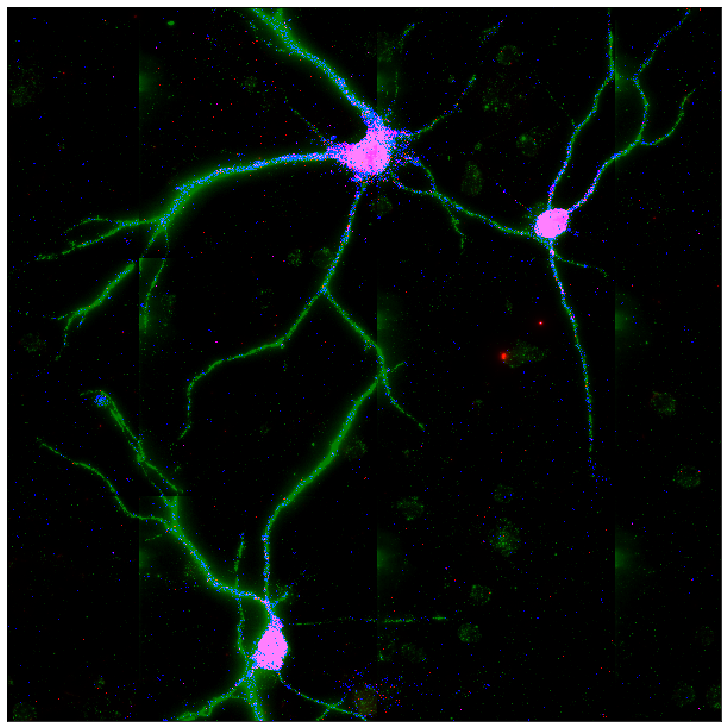

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [3]:
plotting.implot(plotting.panel(preprocessed, bbox, 1), interpolation="None", name="preprocess")

### Dendrite rate distributions

In [2]:
### barcode distributions
labeled_rna = RNA[RNA['cell_index'] > 0]
labeled_rna = labeled_rna[labeled_rna['barcode_id'] > 400]
labeled_rna['dendritic'] = labeled_rna['process_index'] > 0
dendrite_rate = labeled_rna.groupby('barcode_id', as_index=False)['dendritic'].mean()
dendrite_rate['is_somatic'] = dendrite_rate['dendritic'] > 0.1

# validate barcodes
validate_rna = RNA_two[RNA_two['cell_index'] > 0]
validate_rna = validate_rna[validate_rna['barcode_id'] > 400]
validate_rna['dendritic'] = validate_rna['process_index'] > 0
dendrite_validate = validate_rna.groupby('barcode_id', as_index=False)['dendritic'].mean()

left, right = dendrite_validate.align(dendrite_rate)
left['is_somatic'] = right['is_somatic']



In [5]:
print(f'calibration average dendritic localization{np.average(labeled_rna["dendritic"])}')
print(f'validation average dendritic localization{np.average(validate_rna["dendritic"])}')

print(f'calibration average dendritic localization rate {np.average(dendrite_rate["dendritic"])}')
print(f'validation average dendritic localization rate {np.average(dendrite_validate["dendritic"])}')

calibration average dendritic localization0.08024219111630182
validation average dendritic localization0.09845831188617496
calibration average dendritic localization rate 0.06105590087458551
validation average dendritic localization rate 0.07903104031556338


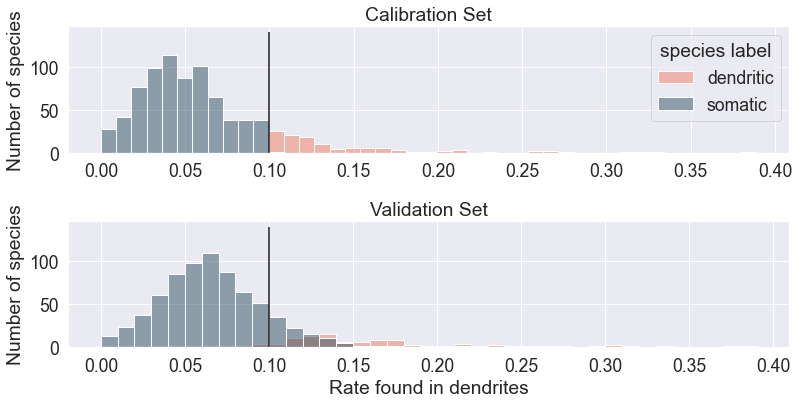

In [5]:
import matplotlib as mpl

mpl.rc('figure', facecolor=[0, 0, 0, 0])
mpl.rc('savefig', dpi=400)

sns.set(font_scale=1.6)
linecolor = 'k'
cmap = [two_map[1], two_map[2]]
shortdim = (11.5, 6)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=shortdim)

ax = axes[0]
sns.histplot(data=dendrite_rate, ax=ax, x='dendritic', hue='is_somatic', palette=cmap)
ax.set_title("Calibration Set")
ax.set_xlabel(None)
ax.set_ylabel("Number of species")
ax.legend(title='species label', labels=['dendritic', 'somatic'])
ax.vlines([0.1], ymin=0, ymax=140, colors=[linecolor])
# plt.savefig(fname=plotpath+'dendritic_rates.png',bbox_inches='tight')

ax = axes[1]
sns.histplot(data=left, ax=ax, x='dendritic', hue='is_somatic', palette=cmap, legend=False)
ax.set_title('Validation Set')
ax.set_xlabel("Rate found in dendrites")
ax.set_ylabel("Number of species")
# plt.legend(title='species label', labels=['dendritic', 'somatic'])
ax.vlines([0.1], ymin=0, ymax=140, colors=[linecolor])
plt.tight_layout()
plt.savefig(fname=plotpath + 'validationdendritc.png', bbox_inches='tight')
plt.show()

### Quantile change vs null

In [6]:
def get_quantiles(arr):
    sorted = np.argsort(arr)
    found = np.array([np.argwhere(sorted == i)[0][0] for i in range(len(arr))])
    quantile = found / len(arr)
    return quantile


left['quantile'] = get_quantiles(np.array(left['dendritic']))
right['quantile'] = get_quantiles(np.array(right['dendritic']))

realdiffs = left['quantile'] - right['quantile']

n = len(left)
permutation_one = np.random.choice(range(n), n, replace=False) / n
permutation_two = np.random.choice(range(n), n, replace=False) / n

simdiffs = permutation_one - permutation_two


In [8]:
print(np.mean(np.abs(realdiffs)))
print(np.mean(np.abs(simdiffs)))

0.13516005347190949
0.33223898704542126


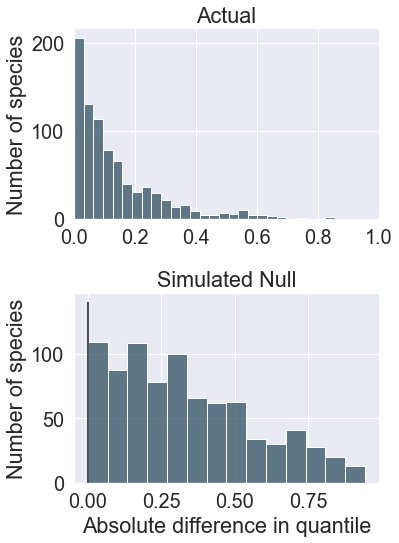

In [7]:
sns.set(font_scale=1.8)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

ax = axes[0]
sns.histplot(np.abs(realdiffs), ax=ax, color=cmap[0])
ax.vlines([0], ymin=0, ymax=140, colors=[linecolor])
ax.set_title("Actual")
ax.set_xlim(0, 1)
ax.set_xlabel(None)
ax.set_ylabel("Number of species")
# plt.savefig(fname=plotpath+'quantilediff.png',bbox_inches='tight')
# plt.show()

ax = axes[1]
sns.histplot(np.abs(simdiffs), ax=ax, color=cmap[0])
ax.vlines([0], ymin=0, ymax=140, colors=[linecolor])
ax.set_title("Simulated Null")
ax.set_xlabel("Absolute difference in quantile")
ax.set_ylabel("Number of species")
plt.tight_layout()
plt.savefig(fname=plotpath + 'realvssimquantile.png', bbox_inches='tight')
plt.show()